In [1]:
import numpy as np
import matplotlib.pyplot as plt
from trainSpringerSegmentationAlgorithm import trainSpringerSegmentationAlgorithm
from runSpringerSegmentationAlgorithm import runSpringerSegmentationAlgorithm
from scipy.signal import envelope, butter, filtfilt

In [2]:
include_wavelet = 0
featuresFs = 50
fs = 1000  # original sampling frequency
# audio_list = [np.loadtxt('train/train_recording_1.txt'),
#               np.loadtxt('train/train_recording_2.txt'),
#               np.loadtxt('train/train_recording_3.txt'),
#               np.loadtxt('train/train_recording_4.txt'),
#               np.loadtxt('train/train_recording_5.txt')
#               ]
# annotations_list = [np.loadtxt('train/train_annotations_1.txt'),
#                     np.loadtxt('train/train_annotations_2.txt'),
#                     np.loadtxt('train/train_annotations_3.txt'),
#                     np.loadtxt('train/train_annotations_4.txt'),
#                     np.loadtxt('train/train_annotations_5.txt')
#                     ]

# logistic_regression_B_matrix, pi_vector, total_obs_distribution = trainSpringerSegmentationAlgorithm(audio_list, annotations_list, fs)

In [3]:
total_obs_distribution_matlab = []
total_obs_distribution_matlab.append(np.array([-7.20188112263631e-17,	-5.59431837204785e-17,	-1.37285858900255e-16]))
total_obs_distribution_matlab.append(np.array([[0.999275887038377,	0.901195017679220,	0.757009773375425],
[0.901195017679220,	0.999275887038378,	0.881206546250959],
[0.757009773375425,	0.881206546250959,	0.999275887038377]]))

logistic_regression_B_matrix_matlab = [
    np.array([0.768601230285194, -2.36916125246872, 1.33401331967011, -0.0154181502251833]),
    np.array([0.0348144193553617, 1.61052273372253, -0.658761710830248, 0.517613213850238]),
    np.array([0.249350696813833, -0.332256305892264, -0.184534572878641, 0.0502171051665354]),
    np.array([0.445874669997996, 3.92243992649834, -1.64384809828363, 0.371850731404145])
]

In [ ]:
audio_test = np.loadtxt('test/test_recording.txt')[10000:20000]

assigned_states = runSpringerSegmentationAlgorithm(
    audio_test,
    fs,
    logistic_regression_B_matrix,
    pi_vector, total_obs_distribution,
    figures=True
    )
# normalize assigned_states from 0 to 1
assigned_states = (assigned_states - np.min(assigned_states)) / (np.max(assigned_states) - np.min(assigned_states))
audio_test = audio_test/np.max(np.abs(audio_test))

In [11]:
audio_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/pcg_cut_matlab.txt')
envol = envelope(audio_train, residual=None)
# low pass filter for the envelope
lowcut = 40.0
fs = 1000.0
b, a = butter(1, lowcut, btype='lowpass', fs=fs)
envol = filtfilt(b, a, envol)
r_peaks_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/R_marks_adjusted.txt', dtype=int)
t_points_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/T_marks_adjusted.txt', dtype=int)
x = np.arange(len(audio_train))

audio_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/pcg_cut_matlab.txt')
r_peaks_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/R_marks_adjusted.txt', dtype=int)
t_points_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/T_marks_adjusted.txt', dtype=int)
envol_test = envelope(audio_test, residual=None)
# low pass filter for the envelope
envol_test = filtfilt(b, a, envol_test)
envol_test = envol_test/np.max(np.abs(envol_test))
x_test = np.arange(len(audio_test))

# Now we segmenting the audio and r_peaks, t_points into 10-second segments
segment_length = 3000  # 10 seconds at 1000 Hz
num_segments = len(audio_train) // segment_length
audio_segments_train = []
envol_segments_train = []
audio_train_annotations = []
for i in range(num_segments):
    start = i * segment_length
    end = (i + 1) * segment_length
    audio_segments_train.append(audio_train[start:end])
    envol_segments_train.append(envol[start:end])
    # r_peaks_segments_train.append(r_peaks_train[(r_peaks_train >= start) & (r_peaks_train < end)] - start)
    # t_points_segments_train.append(t_points_train[(t_points_train >= start) & (t_points_train < end)] - start)
    # we need to add the r_peaks and t_points as array of Nx2, where thre first column are the r_peaks and the second column are the t_points
    r_peaks_segment = r_peaks_train[(r_peaks_train >= start) & (r_peaks_train < end)] - start
    r_peaks_segment = np.rint(r_peaks_segment/20)
    t_points_segment = t_points_train[(t_points_train >= start) & (t_points_train < end)] - start
    t_points_segment = np.rint(t_points_segment/20)

    if len(r_peaks_segment) > len(t_points_segment):
        r_peaks_segment = r_peaks_segment[:len(t_points_segment)]
    elif len(t_points_segment) > len(r_peaks_segment):
        t_points_segment = t_points_segment[1:len(t_points_segment)]
    # concatenate the r_peaks and t_points into a single array of Nx2
    annotations = np.vstack((r_peaks_segment, t_points_segment)).T
    audio_train_annotations.append(annotations)

# The same for the test set
segment_test_length = 10000
num_segments_test = len(audio_test) // segment_test_length
audio_segments_test = []
envol_segments_test = []
audio_test_annotations = []
for i in range(num_segments_test):
    start = i * segment_test_length
    end = (i + 1) * segment_test_length
    audio_segments_test.append(audio_test[start:end])
    envol_segments_test.append(envol_test[start:end])
    # r_peaks_segments_test.append(r_peaks_test[(r_peaks_test >= start) & (r_peaks_test < end)] - start)
    # t_points_segments_test.append(t_points_test[(t_points_test >= start) & (t_points_test < end)] - start)
    r_peaks_segment = r_peaks_test[(r_peaks_test >= start) & (r_peaks_test < end)] - start
    t_points_segment = t_points_test[(t_points_test >= start) & (t_points_test < end)] - start

    if len(r_peaks_segment) > len(t_points_segment):
        r_peaks_segment = r_peaks_segment[:len(t_points_segment)]
    elif len(t_points_segment) > len(r_peaks_segment):
        t_points_segment = t_points_segment[1:len(t_points_segment)]
    annotations = np.vstack((r_peaks_segment, t_points_segment)).T
    audio_test_annotations.append(annotations)

logistic_regression_B_matrix, pi_vector, total_obs_distribution = trainSpringerSegmentationAlgorithm(audio_segments_train, audio_train_annotations, fs)

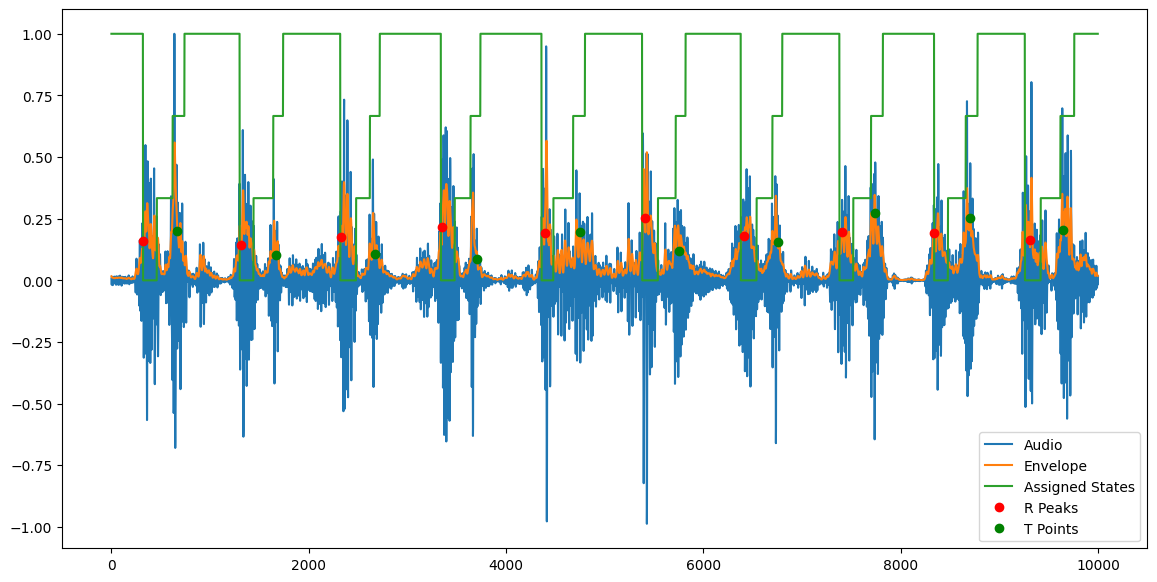

In [41]:
n = np.random.randint(0, num_segments_test - 1)
x = np.arange(len(audio_segments_test[n]))
assigned_states = runSpringerSegmentationAlgorithm(
    audio_segments_test[n],
    fs,
    logistic_regression_B_matrix,
    pi_vector, total_obs_distribution,
    figures=False
    )
assigned_states = (assigned_states - np.min(assigned_states)) / (np.max(assigned_states) - np.min(assigned_states))
plt.figure(figsize=(14, 7))
plt.plot(audio_segments_test[n]/np.max(np.abs(audio_segments_test[n])), label='Audio')
plt.plot(envol_segments_test[n], label='Envelope')
plt.plot(assigned_states, label='Assigned States')
plt.plot(x[audio_test_annotations[n][:,0]], envol_segments_test[n][audio_test_annotations[n][:,0]], 'ro', label='R Peaks')
plt.plot(x[audio_test_annotations[n][:,1]], envol_segments_test[n][audio_test_annotations[n][:,1]], 'go', label='T Points')
plt.legend()
plt.show()

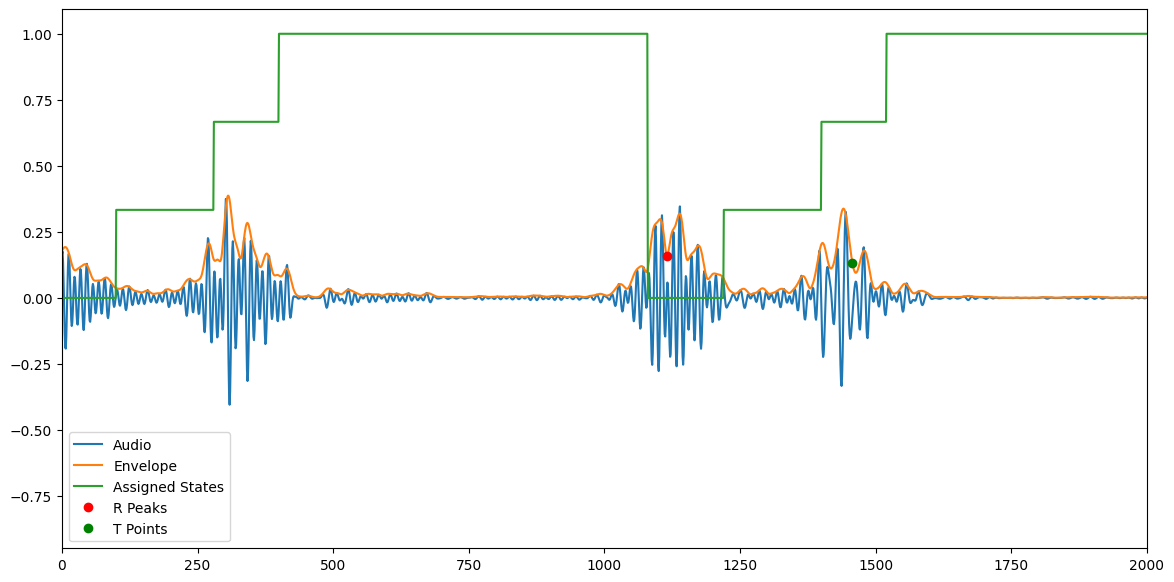

In [65]:
plt.figure(figsize=(14, 7))
plt.plot(audio_segments_test[n]/np.max(np.abs(audio_segments_test[n])), label='Audio')
plt.plot(envol_segments_test[n], label='Envelope')
plt.plot(assigned_states, label='Assigned States')
plt.plot(x[audio_test_annotations[n][:,0]], envol_segments_test[n][audio_test_annotations[n][:,0]], 'ro', label='R Peaks')
plt.plot(x[audio_test_annotations[n][:,1]], envol_segments_test[n][audio_test_annotations[n][:,1]], 'go', label='T Points')
plt.legend()
plt.xlim(0, 2000)
plt.show()